# 필요 라이브러리 다운로드

In [ ]:
!pip install transformers
!pip install evaluate

# 문어체 구어체 분류기

In [9]:
import pandas as pd
import torch
import random
import os
import numpy as np
import evaluate

In [10]:
CFG = {
    'EPOCHS': 3,
    'LEARNING_RATE':1e-5,
    'BATCH_SIZE':64,
    'SEED':41
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [18]:
from sklearn.model_selection import train_test_split

In [38]:
구어체_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/data/구어체_train.csv")[['원문']]
구어체_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/data/구어체_val.csv")[['원문']]
구어체_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/data/구어체_test.csv")[['원문']]
문어체_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/data/문어체_train.csv")[['원문']]
문어체_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/data/문어체_val.csv")[['원문']]
문어체_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/data/문어체_val.csv")[['원문']]

구어체_train['label'], 구어체_val['label'], 문어체_train['label'], 문어체_val['label'] = 0, 0, 1, 1
train, val = pd.concat([구어체_train, 문어체_train]).reset_index(drop = True), pd.concat([구어체_val, 문어체_val]).reset_index(drop = True)

_, train = train_test_split(train, test_size=10500, shuffle=True, random_state=CFG['SEED'], stratify = train['label'])
_, test = train_test_split(val, test_size=4500, shuffle=True, random_state=CFG['SEED'], stratify = val['label'])
val, test = train_test_split(test, test_size=1500, shuffle=True, random_state=CFG['SEED'], stratify = test['label'])

train, val, test = train.reset_index(drop = True), val.reset_index(drop = True), test.reset_index(drop = True)

In [11]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, DataCollatorForSeq2Seq, Trainer, EncoderDecoderModel, EarlyStoppingCallback

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base", use_fast = True)
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels = 2)

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

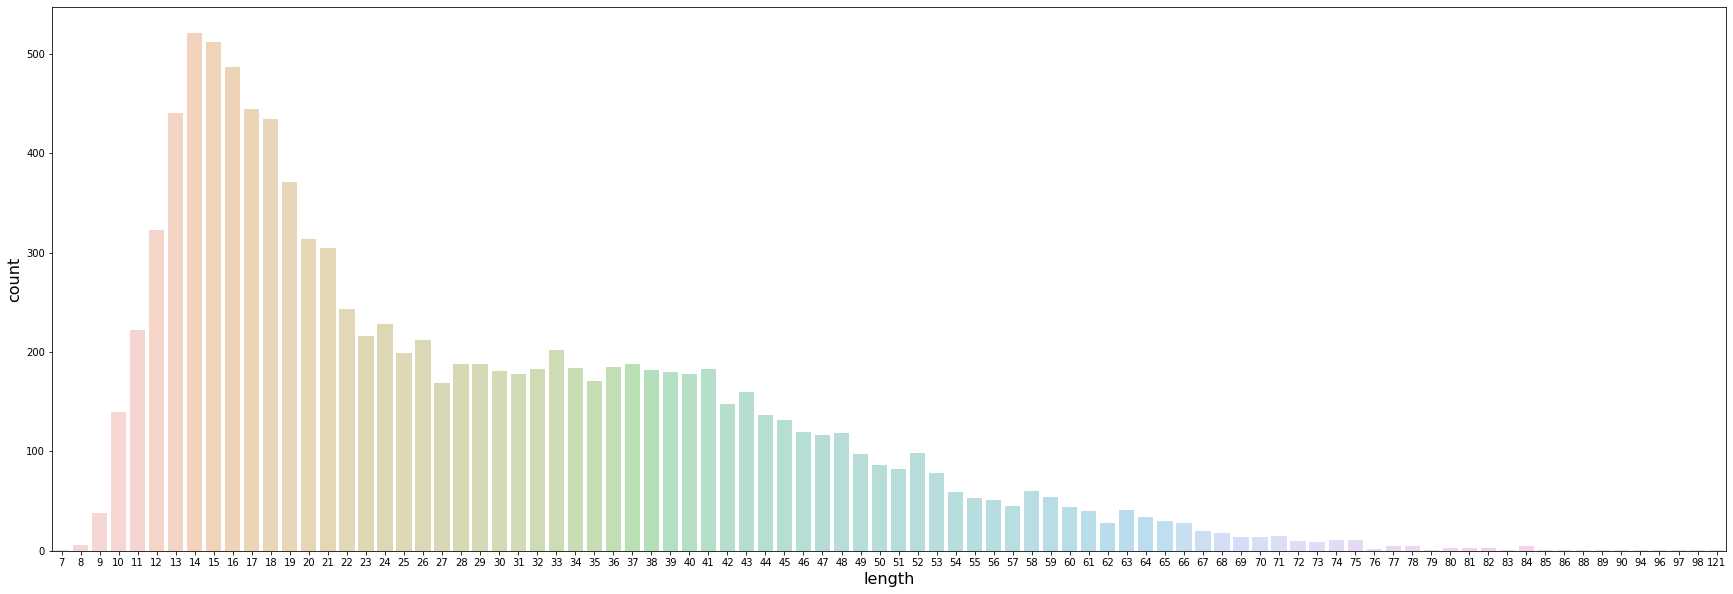

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def tokenizing(text):
    return tokenizer(text)['input_ids']

count = Counter([len(c) for c in map(tokenizing, train['원문'].tolist())])
count = dict(sorted(count.items(), key = lambda x:-x[1]))

plt.figure(figsize=(30, 10))
g = sns.barplot(x = list(count.keys()),
                y = list(count.values()),
                alpha = .4)

g.set_xlabel('length', fontsize=16)
g.set_ylabel('count', fontsize=16)

g

In [14]:
class CustomDataset:
    def __init__(self, data, mode = "train"):
        self.dataset = data
        self.tokenizer = tokenizer
        self.mode = mode
        
    def __len__(self):
        return len(self.dataset)
  
    def __getitem__(self, idx):
        text = self.dataset['원문'][idx]
        inputs = self.tokenizer(text, padding='max_length', max_length = 200, truncation=True, return_tensors="pt")
        input_ids = inputs['input_ids'][0]
        token_type_ids = inputs['token_type_ids'][0]
        attention_mask = inputs['attention_mask'][0]
    
        if self.mode == "train":
            y = self.dataset['label'][idx]
            return {"input_ids": input_ids, "token_type_ids": token_type_ids, "attention_mask": attention_mask, "label": torch.tensor([y])}
        else:
            return {"input_ids": input_ids, "token_type_ids": token_type_ids, "attention_mask": attention_mask}

In [40]:
train = CustomDataset(train, mode = "train")
valid = CustomDataset(val, mode = "train")
test = CustomDataset(test, mode = "test")

In [23]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [12]:
arguments = TrainingArguments(
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    gradient_accumulation_steps=4,
    save_total_limit=5,
    # dataloader_num_workers=2,
    # fp16=True,
    load_best_model_at_end=True,
    output_dir="/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/klue-bert-dataset-" + str(len(train) + len(val) + len(test)
)

trainer = Trainer(
    model,
    arguments,
    train_dataset=train,
    eval_dataset=valid,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

trainer.train()

# model.save_pretrained("/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model")
trainer.save_model(f"/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/klue-bert-dataset-" + str(len(train) + len(val) + len(test)))
# %%

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10500
  Num Epochs = 20
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 3280
  Number of trainable parameters = 110618882


Epoch,Training Loss,Validation Loss,Accuracy
0,0.220900,0.042180,0.985000
1,0.037800,0.054016,0.985000
2,0.020900,0.076183,0.984667
3,0.007500,0.047592,0.988667
4,0.002500,0.074838,0.988000
5,0.000200,0.076754,0.987000


***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/checkpoint-164
Configuration saved in /content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/checkpoint-164/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/checkpoint-164/pytorch_model.bin
Deleting older checkpoint [/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/checkpoint-208] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/checkpoint-328
Configuration saved in /content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/checkpoint-328/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/checkpoint-328/pytorch_model.bin
Deleting older

# 분류 결과

In [42]:
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/klue-bert-dataset-15000")

arguments = TrainingArguments(
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    gradient_accumulation_steps=4,
    save_total_limit=5,
    # dataloader_num_workers=2,
    # fp16=True,
    load_best_model_at_end=True,
    output_dir="/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/klue-bert-dataset-15000"
)

trainer = Trainer(
    model,
    arguments,
    train_dataset=train,
    eval_dataset=valid,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

import torch.nn.functional as F

model.eval()
test_results = trainer.predict(test)
test_probabilities = F.softmax(torch.from_numpy(test_results.predictions), dim=-1)

print("test_probabilities: ", np.argmax(test_probabilities, axis=-1))

loading configuration file /content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/klue-bert-dataset-15000/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/Colab Notebooks/\u1100\u116e\u1105\u1173\u11b7/goorm_proj3/best_model/klue-bert-dataset-15000",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading weights file /content/drive/MyDrive/Colab Not

test_probabilities:  tensor([1, 1, 1,  ..., 0, 0, 0])


In [ ]:
# model = AutoModelForSequenceClassification.from_pretrained(f"/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/best-model")
# import torch.nn.functional as F

# model.eval()
# 구어체_test_results, 문어체_test_results = trainer.predict(구어체_test), trainer.predict(문어체_test)
# 구어체_probabilities, 문어체_probabilities = F.softmax(torch.from_numpy(구어체_test_results.predictions), dim=-1), F.softmax(torch.from_numpy(문어체_test_results.predictions), dim=-1)

# print("구어체 예측 라벨: ", np.argmax(구어체_test_results.predictions, axis=-1))
# print("문어체 예측 라벨: ", np.argmax(문어체_test_results.predictions, axis=-1))

# 스타일이 없는 문장으로 손상시키기

In [ ]:
class ClassifacionDataset:
    def __init__(self, data, mode = "train"):
        self.dataset = data
        self.tokenizer = tokenizer
        self.mode = mode
        
    def __len__(self):
        return len(self.dataset)
  
    def __getitem__(self, idx):
        text = self.dataset['원문'][idx]
        inputs = self.tokenizer(text, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
        input_ids = inputs['input_ids'][0]
        token_type_ids = inputs['token_type_ids'][0]
        attention_mask = inputs['attention_mask'][0]
        input_list = []
        for i in range(2, len(input_ids)):
            input = self.tokenizer(tokenizer.decode((input_ids[i:i+1] + input_ids[i+1:-1])), padding='max_length', max_length = 512, truncation=True, return_tensors="pt")
            input_list.append({"input_ids" : input['input_ids'][0], "token_type_ids" : input['token_type_ids'][0], "attention_mask": input['attention_mask'][0]})
        return input_list

In [ ]:
구어체_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/data/구어체_train.csv")[['원문']][:2500]
train = ClassifacionDataset(구어체_train)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(f"/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model/best-model")

arguments = TrainingArguments(
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=20,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,
    gradient_accumulation_steps=3,
    save_total_limit=5,
    # dataloader_num_workers=2,
    # fp16=True,
    load_best_model_at_end=True,
    output_dir="/content/drive/MyDrive/Colab Notebooks/구름/goorm_proj3/best_model"
)

trainer = Trainer(
    model,
    arguments,
    train_dataset=train,
    eval_dataset=valid,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

In [ ]:
model.eval()

reslut = trainer.predict(문어체_test)
F.softmax(torch.from_numpy(reslut.predictions), dim=-1)

***** Running Prediction *****
  Num examples = 2500
  Batch size = 16


TypeError: ignored

In [123]:
tokenizer(i)['input_ids']

[2,
 717,
 2259,
 5771,
 4612,
 2116,
 30901,
 2131,
 3683,
 3994,
 2170,
 3643,
 22819,
 1335,
 2088,
 3880,
 19521,
 1335,
 10283,
 18,
 3]

In [144]:
for i in train['원문'][:10]:
    input_ids = tokenizer(i, add_special_tokens = False)['input_ids']
    for j in range(len(input_ids)):
        p = input_ids.pop(j)
        print(tokenizer.decode(input_ids))
        input_ids.insert(j, p)

##는 비록 영어가 서투르지만 당신에 대해 알고 싶고 얘기하고 싶어요.
나 비록 영어가 서투르지만 당신에 대해 알고 싶고 얘기하고 싶어요.
나는 영어가 서투르지만 당신에 대해 알고 싶고 얘기하고 싶어요.
나는 비록가 서투르지만 당신에 대해 알고 싶고 얘기하고 싶어요.
나는 비록 영어 서투르지만 당신에 대해 알고 싶고 얘기하고 싶어요.
나는 비록 영어가르지만 당신에 대해 알고 싶고 얘기하고 싶어요.
나는 비록 영어가 서투지만 당신에 대해 알고 싶고 얘기하고 싶어요.
나는 비록 영어가 서투르 당신에 대해 알고 싶고 얘기하고 싶어요.
나는 비록 영어가 서투르지만에 대해 알고 싶고 얘기하고 싶어요.
나는 비록 영어가 서투르지만 당신 대해 알고 싶고 얘기하고 싶어요.
나는 비록 영어가 서투르지만 당신에 알고 싶고 얘기하고 싶어요.
나는 비록 영어가 서투르지만 당신에 대해 싶고 얘기하고 싶어요.
나는 비록 영어가 서투르지만 당신에 대해 알고고 얘기하고 싶어요.
나는 비록 영어가 서투르지만 당신에 대해 알고 싶 얘기하고 싶어요.
나는 비록 영어가 서투르지만 당신에 대해 알고 싶고하고 싶어요.
나는 비록 영어가 서투르지만 당신에 대해 알고 싶고 얘기 싶어요.
나는 비록 영어가 서투르지만 당신에 대해 알고 싶고 얘기하고어요.
나는 비록 영어가 서투르지만 당신에 대해 알고 싶고 얘기하고 싶.
나는 비록 영어가 서투르지만 당신에 대해 알고 싶고 얘기하고 싶어요
##은 행복한 나날을 보내지만, 아버지가 자꾸 생각납니다.
심청 행복한 나날을 보내지만, 아버지가 자꾸 생각납니다.
심청은한 나날을 보내지만, 아버지가 자꾸 생각납니다.
심청은 행복 나날을 보내지만, 아버지가 자꾸 생각납니다.
심청은 행복한을 보내지만, 아버지가 자꾸 생각납니다.
심청은 행복한 나날 보내지만, 아버지가 자꾸 생각납니다.
심청은 행복한 나날을지만, 아버지가 자꾸 생각납니다.
심청은 행복한 나날을 보내, 아버지가 자꾸 생각납니다.
심청은 행복한 나날을 보내지만 아버지가 자꾸 생각납니다.
심청은 행복한 나날을 보

In [143]:
token_idx.shape[1]

13